# Jakub Kasperski

# Lab 4: Model-Based Offline Optimization

In this lab, we explore **Model-Based Offline Optimization (MBO)**, a method to optimize black-box functions using only a pre-collected dataset, without additional function evaluations. We'll use two functions from the **Black-Box Optimization Benchmarking (BBOB)** suite:
- **f1** [Sphere Function](https://numbbo.github.io/gforge/downloads/download16.00/bbobdocfunctions.pdf#page=5): A simple, unimodal function with a global minimum at (0, 0).
- **f22** [Gallagher's Gaussian 21-hi Peaks Function](https://numbbo.github.io/gforge/downloads/download16.00/bbobdocfunctions.pdf#page=110): A complex, multimodal function with many local optima.

Visualizations of these problems are available [here](https://coco-platform.org/testsuites/bbob/viz.html?col=3&dim=2&fun=1&ins=1&typ=all).

### Objectives
1. **Dataset:** Use pre-collected datasets (100k samples each) for f1 and f22, generated via **Latin Hypercube Sampling (LHS)** [learn more about LHS here](https://en.wikipedia.org/wiki/Latin_hypercube_sampling).
2. **Surrogate Model:** Train a Multi-Layer Perceptron (MLP) to approximate these functions.
3. **Visualization:** Compare the MLP's predictions to the true functions using contour and scatter plots.
4. **Optimization:** Implement gradient-based optimization on the MLP to find optimal points.
5. **Experiments:** Investigate how training dataset size and model complexity affect performance.

### Key Concepts
- **Offline Optimization:** No new evaluations of the true function are allowed; we rely solely on the dataset.
- **Surrogate Model:** The MLP acts as a cheap, differentiable proxy for the expensive black-box function.
- **Gradient-Based Optimization:** Use the MLP's gradients to find optimal designs efficiently.

In [12]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd

device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

In [13]:
device

device(type='cpu')

### 1. Data Preparation

We start by loading and splitting the dataset into training, validation, and test sets.

In [36]:
def prepare_dataloaders(
    file_path: str,
    batch_size: int = 256,
    train_perc: float = 0.6,
    val_perc: float = 0.2,
) -> tuple[DataLoader, DataLoader, DataLoader]:
    """
    Prepare train, validation and test dataloaders.

    Args:
        file_path: Path to CSV data file
        batch_size: Batch size for dataloaders
        train_perc: Percentage of data for training
        val_perc: Percentage of data for validation
    """
    # Load data
    data_df = pd.read_csv(file_path)
    X = torch.tensor(data_df[["x1", "x2"]].values, dtype=torch.float32)
    y = torch.tensor(data_df["y"].values.reshape(-1, 1), dtype=torch.float32)

    # Split data
    num_samples = len(X)
    indices = np.random.permutation(num_samples)
    train_size = int(train_perc * num_samples)
    val_size = int(val_perc * num_samples)

    # Create datasets
    train_dataset = TensorDataset(X[indices[:train_size]], y[indices[:train_size]])
    val_dataset = TensorDataset(
        X[indices[train_size : train_size + val_size]],
        y[indices[train_size : train_size + val_size]],
    )
    test_dataset = TensorDataset(
        X[indices[train_size + val_size :]], y[indices[train_size + val_size :]]
    )

    # Create dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, persistent_workers=True, num_workers=2)  # pin_memory=
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, persistent_workers=True, num_workers=2)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, persistent_workers=True, num_workers=2)

    return train_dataloader, val_dataloader, test_dataloader

# Example usage (replace with your file path)
train_dataloader, val_dataloader, test_dataloader = prepare_dataloaders(
    "./bbob_f022_i01_d02_samples.csv", train_perc=0.3, val_perc=0.4
)

### 2. Define the MLP Model

The MLP will serve as our surrogate model to approximate the black-box function.

In [15]:
class MLP(nn.Module):
    def __init__(
        self, input_dim: int = 2, hidden_dim: int = 256, n_layers: int = 3
    ) -> None:
        """
        Multi-Layer Perceptron (MLP) for function approximation.

        Args:
            input_dim (int): Number of input features (e.g., 2 for x1, x2).
            hidden_dim (int): Number of neurons in each hidden layer.
            n_layers (int): Total number of layers (input + hidden + output).
        """
        super(MLP, self).__init__()

        layers = []
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())

        # Hidden layers
        for _ in range(n_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())

        # Output layer -> 1 output neuron (regression, single-objective problem)
        layers.append(nn.Linear(hidden_dim, 1))

        self.model = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

### 3. Training the Model

We train the MLP using the Adam optimizer and Mean Squared Error (MSE) loss.

In [16]:
model = MLP().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for inputs, targets in train_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    train_loss = train_loss / len(train_dataloader.dataset)
    train_losses.append(train_loss)
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    val_loss = val_loss / len(val_dataloader.dataset)
    val_losses.append(val_loss)
    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
        )

model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)

test_loss = test_loss / len(test_dataloader.dataset)
print(f"Test Loss: {test_loss:.4f}")

Epoch 10/100, Train Loss: 532.0911, Val Loss: 488.7866
Epoch 20/100, Train Loss: 344.6416, Val Loss: 335.8414
Epoch 30/100, Train Loss: 281.9923, Val Loss: 272.1904
Epoch 40/100, Train Loss: 233.3644, Val Loss: 224.9243
Epoch 50/100, Train Loss: 200.5548, Val Loss: 194.4627
Epoch 60/100, Train Loss: 182.3191, Val Loss: 177.1246
Epoch 70/100, Train Loss: 173.6266, Val Loss: 176.4619
Epoch 80/100, Train Loss: 162.4332, Val Loss: 178.1826
Epoch 90/100, Train Loss: 156.9070, Val Loss: 160.4239
Epoch 100/100, Train Loss: 146.9395, Val Loss: 140.8214
Test Loss: 141.3437


### 4. Visualization

Let's visualize how well the MLP approximates the true function.

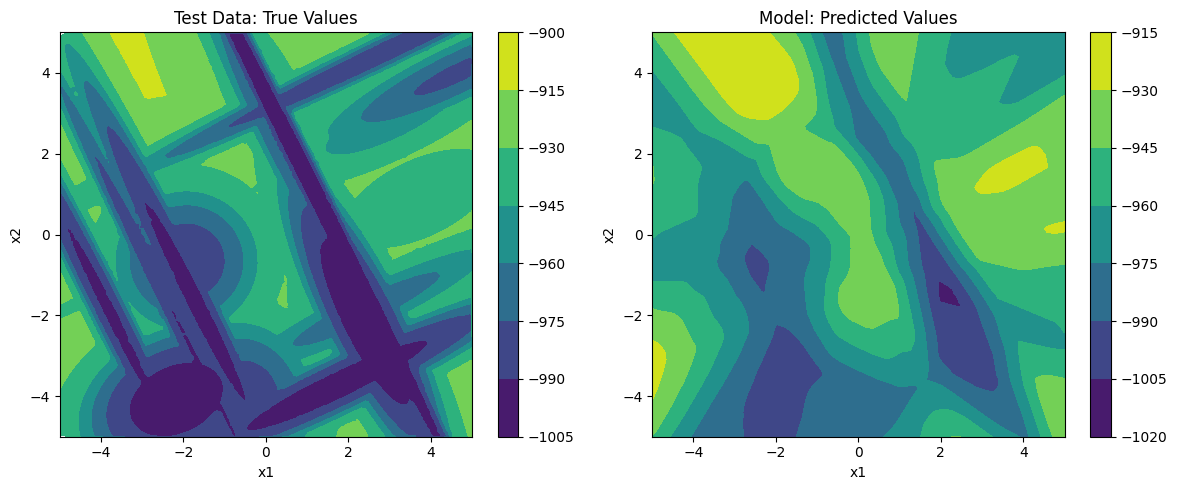

In [17]:
def plot_contour_comparison(
    model: nn.Module, test_dataloader: DataLoader, device: torch.device
) -> None:
    test_inputs_list = []
    test_targets_list = []

    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        test_inputs_list.append(inputs.cpu().numpy())
        test_targets_list.append(targets.cpu().numpy())

    test_inputs = np.vstack(test_inputs_list)
    test_targets = np.concatenate(test_targets_list)

    x1_min, x1_max = test_inputs[:, 0].min(), test_inputs[:, 0].max()
    x2_min, x2_max = test_inputs[:, 1].min(), test_inputs[:, 1].max()
    x1_vals = np.linspace(x1_min, x1_max, 100)
    x2_vals = np.linspace(x2_min, x2_max, 100)
    X1, X2 = np.meshgrid(x1_vals, x2_vals)

    grid_points = np.column_stack((X1.flatten(), X2.flatten()))
    grid_tensor = torch.tensor(grid_points, dtype=torch.float32, device=device)

    model.eval()
    with torch.no_grad():
        predictions = model(grid_tensor).cpu().numpy().flatten()

    Z_pred = predictions.reshape(X1.shape)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    true_contour = ax1.tricontourf(
        test_inputs[:, 0], test_inputs[:, 1], test_targets.reshape(-1)
    )
    ax1.set_title("Test Data: True Values")
    ax1.set_xlabel("x1")
    ax1.set_ylabel("x2")
    plt.colorbar(true_contour, ax=ax1)

    pred_contour = ax2.contourf(X1, X2, Z_pred)
    ax2.set_title("Model: Predicted Values")
    ax2.set_xlabel("x1")
    ax2.set_ylabel("x2")
    plt.colorbar(pred_contour, ax=ax2)

    plt.tight_layout()
    plt.show()

plot_contour_comparison(model, test_dataloader, device)

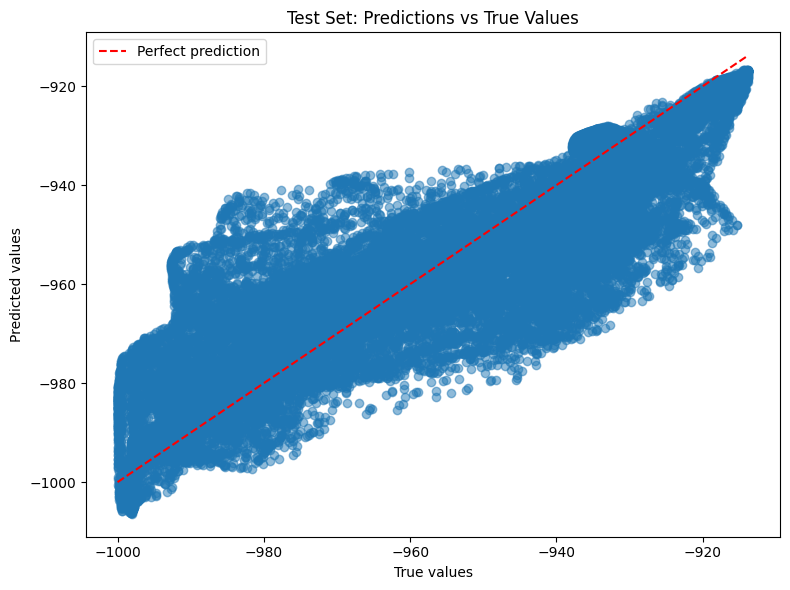

In [18]:
def plot_prediction_scatter(
    model: nn.Module, test_dataloader: DataLoader, device: torch.device
) -> None:
    test_targets_list = []
    test_preds_list = []

    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        with torch.no_grad():
            outputs = model(inputs)

        test_targets_list.append(targets.cpu().numpy())
        test_preds_list.append(outputs.cpu().numpy())

    test_targets = np.concatenate(test_targets_list)
    test_preds = np.concatenate(test_preds_list).flatten()

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(test_targets, test_preds, alpha=0.5)
    ax.plot(
        [test_targets.min(), test_targets.max()],
        [test_targets.min(), test_targets.max()],
        "r--",
        label="Perfect prediction",
    )
    ax.set_xlabel("True values")
    ax.set_ylabel("Predicted values")
    ax.set_title("Test Set: Predictions vs True Values")
    ax.legend()

    plt.tight_layout()
    plt.show()


plot_prediction_scatter(model, test_dataloader, device)

### 5. Gradient-Based Optimization

Now, we optimize the trained MLP to find the input that minimizes its output (our surrogate's prediction).

In [21]:
def optimize_model(
    model: nn.Module, num_steps: int = 1000
) -> tuple[torch.Tensor, float]:
    """
    Perform gradient-based optimization on the MLP.

    Args:
        model (nn.Module): Trained MLP model.
        num_steps (int): Number of optimization steps.

    Returns:
        tuple: (best_x, best_y) - Optimal input and its predicted output.
    """
    model.eval()
    # Select random starting point in [-5, 5]^2
    x = torch.rand(1, 2, device=device) * 10 - 5
    x.requires_grad_(True)

    best_x = x.copy_()
    best_y = float("inf")

    optimizer = torch.optim.Adam([x], lr=0.001)

    for _ in range(num_steps):
        optimizer.zero_grad()
        # Predict output (our output - result of the model is the function we want to minimize)
        output = model(x)
        # Compute gradients (gradients of our model)
        x.backward()
        # Update x
        if output < best_y:
            best_x = x.copy_()
            best_y = output

        optimizer.step()

        # Enforce domain constraints [-5, 5]
        x.clamp_(-5, 5)

    return best_x, best_y

### Exercise 1: Impact of Dataset Size
- **Task:** Train the MLP with different training set sizes (e.g., 100, 1000, 5000, 10000, 50000).
- **Instructions:**
  1. Modify the `train_perc` parameter in `prepare_dataloaders` to achieve these different dataset sizes (keep the test set size fixed at approximately 30,000 samples).
  2. Train the model for each dataset size and generate corresponding contour plots.
  3. Analyze how the MLP's ability to capture the underlying function structure (particularly the multimodal nature of f22) improves with increasing data volume.
  4. Select and justify a single quantitative metric that effectively captures the model’s predictive quality in this context. Use this metric to evaluate model performance across different training set sizes. Present the results as a plot to visualize how model quality scales with data availability.

In [31]:
dataset_size = 256 * (len(train_dataloader) + len(val_dataloader) + len(test_dataloader))
train_set_sizes = [100, 1000, 5000, 10000, 50000]
test_perc = 0.7





Train set size: 256
Epoch 10/100, Train Loss: 908598.6250, Val Loss: 905184.2484
Epoch 20/100, Train Loss: 883835.5000, Val Loss: 879831.4882
Epoch 30/100, Train Loss: 845580.3125, Val Loss: 841049.1627
Epoch 40/100, Train Loss: 790843.5000, Val Loss: 785964.2322
Epoch 50/100, Train Loss: 717777.1250, Val Loss: 712890.1312
Epoch 60/100, Train Loss: 626790.5625, Val Loss: 622382.3756
Epoch 70/100, Train Loss: 521418.0625, Val Loss: 518025.3542
Epoch 80/100, Train Loss: 408912.0000, Val Loss: 406967.9796
Epoch 90/100, Train Loss: 300071.9062, Val Loss: 299710.4672
Epoch 100/100, Train Loss: 207499.3906, Val Loss: 208344.6724
Test Loss: 206017.6643


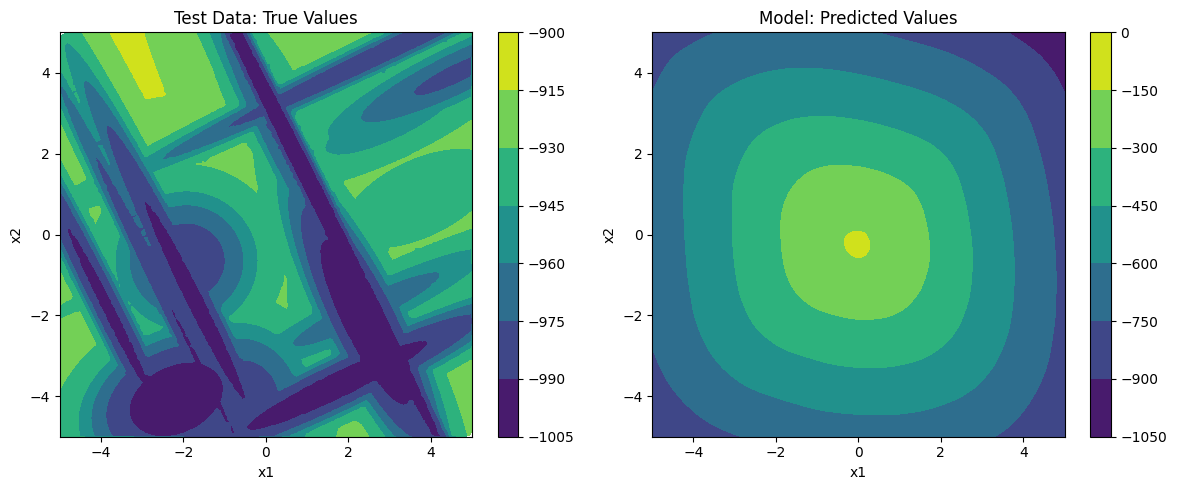

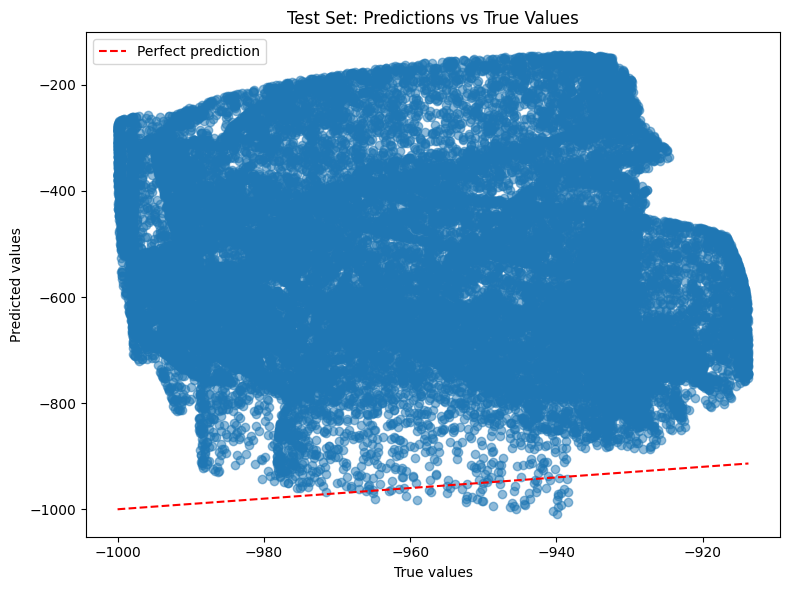

Train set size: 1024
Epoch 10/100, Train Loss: 792626.0266, Val Loss: 774836.0122
Epoch 20/100, Train Loss: 401575.7998, Val Loss: 370313.2061
Epoch 30/100, Train Loss: 103646.5651, Val Loss: 96398.2802
Epoch 40/100, Train Loss: 84216.1798, Val Loss: 81932.7512
Epoch 50/100, Train Loss: 79499.2866, Val Loss: 77571.6024
Epoch 60/100, Train Loss: 75095.9414, Val Loss: 73268.1132
Epoch 70/100, Train Loss: 70449.4850, Val Loss: 68704.3634
Epoch 80/100, Train Loss: 65509.1638, Val Loss: 63837.3155
Epoch 90/100, Train Loss: 60263.0278, Val Loss: 58708.5708
Epoch 100/100, Train Loss: 54809.6116, Val Loss: 53335.3370
Test Loss: 53151.3447


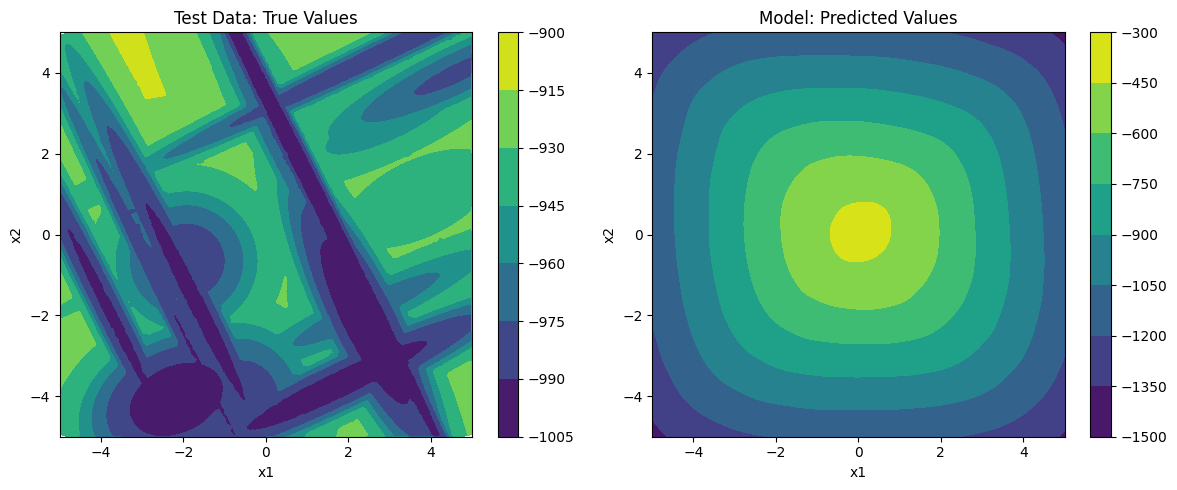

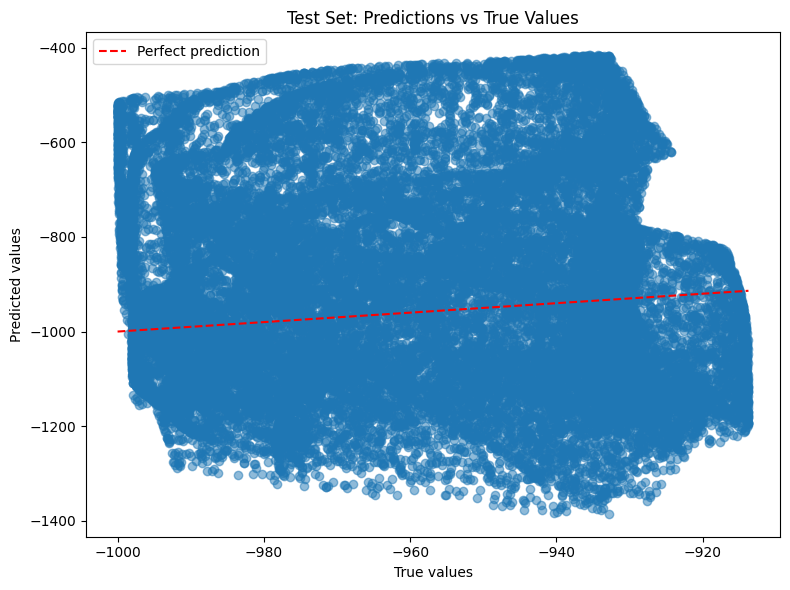

Train set size: 5120
Epoch 10/100, Train Loss: 79232.3588, Val Loss: 79640.9825
Epoch 20/100, Train Loss: 57688.2959, Val Loss: 57391.4554
Epoch 30/100, Train Loss: 30663.7481, Val Loss: 29553.6688
Epoch 40/100, Train Loss: 7655.8084, Val Loss: 6976.0884
Epoch 50/100, Train Loss: 1018.6755, Val Loss: 929.5792
Epoch 60/100, Train Loss: 523.9758, Val Loss: 508.8985
Epoch 70/100, Train Loss: 447.0363, Val Loss: 433.1059
Epoch 80/100, Train Loss: 404.3564, Val Loss: 395.1748
Epoch 90/100, Train Loss: 380.2629, Val Loss: 373.1144
Epoch 100/100, Train Loss: 363.8020, Val Loss: 356.2618
Test Loss: 358.3700


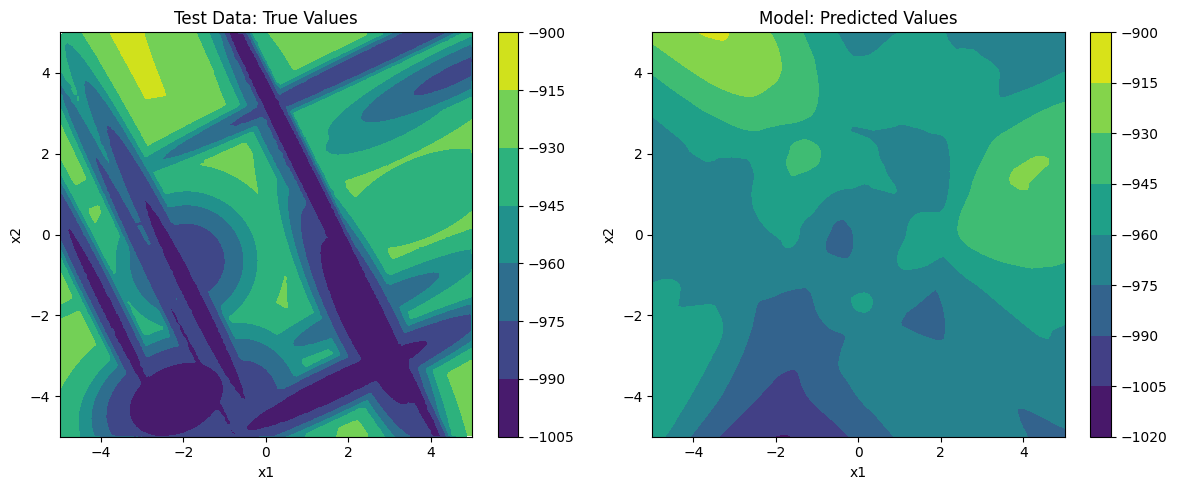

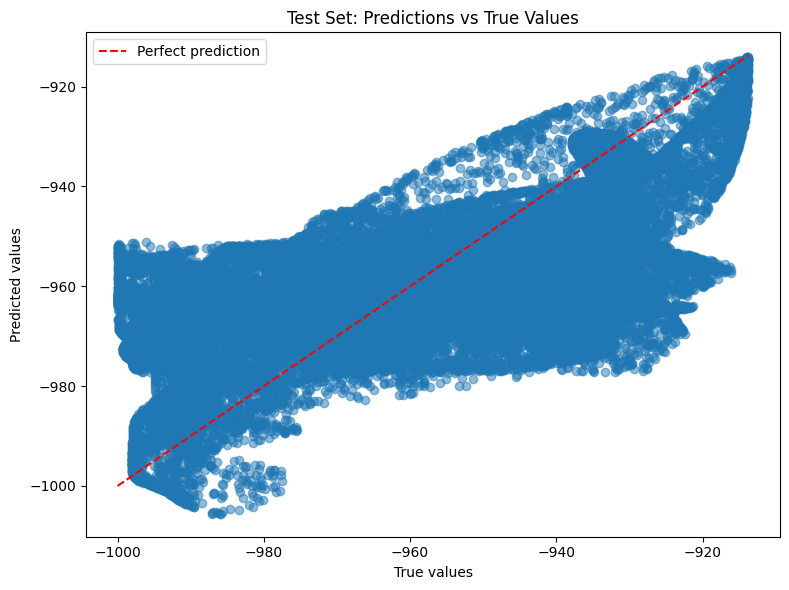

Train set size: 9984
Epoch 10/100, Train Loss: 54905.0368, Val Loss: 51764.9552
Epoch 20/100, Train Loss: 7700.6537, Val Loss: 6446.7616
Epoch 30/100, Train Loss: 534.6782, Val Loss: 523.5788
Epoch 40/100, Train Loss: 409.4218, Val Loss: 410.4714
Epoch 50/100, Train Loss: 364.0508, Val Loss: 366.8653
Epoch 60/100, Train Loss: 328.4566, Val Loss: 330.7619
Epoch 70/100, Train Loss: 300.1048, Val Loss: 303.3608
Epoch 80/100, Train Loss: 274.9255, Val Loss: 279.2006
Epoch 90/100, Train Loss: 257.7971, Val Loss: 259.1319
Epoch 100/100, Train Loss: 240.1259, Val Loss: 241.2348
Test Loss: 239.7701


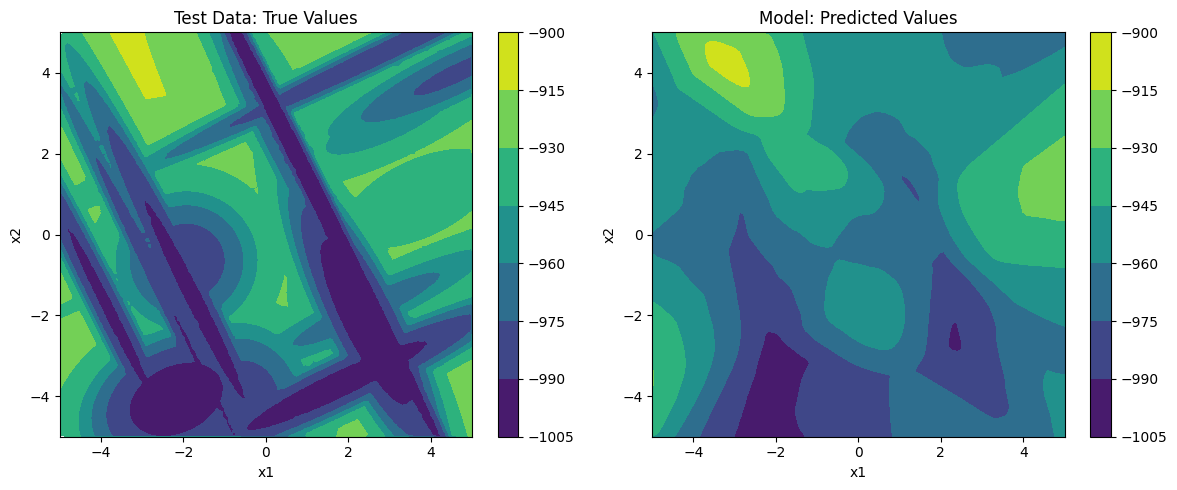

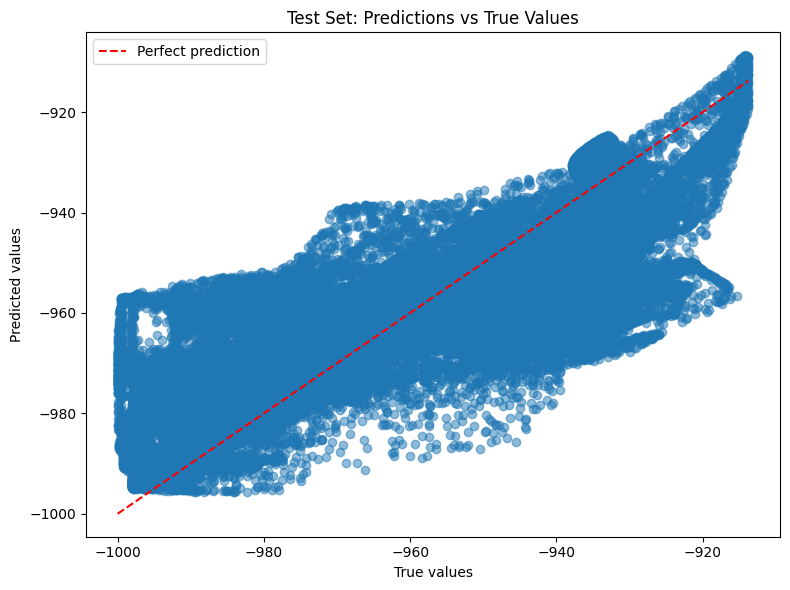

Train set size: 49920
Epoch 10/100, Train Loss: 369.7911, Val Loss: 364.8324
Epoch 20/100, Train Loss: 246.4368, Val Loss: 247.2068
Epoch 30/100, Train Loss: 191.2926, Val Loss: 190.5941
Epoch 40/100, Train Loss: 168.0565, Val Loss: 181.7697
Epoch 50/100, Train Loss: 155.5186, Val Loss: 154.7932
Epoch 60/100, Train Loss: 148.4171, Val Loss: 158.6778
Epoch 70/100, Train Loss: 143.7478, Val Loss: 153.5085
Epoch 80/100, Train Loss: 140.0125, Val Loss: 137.8709
Epoch 90/100, Train Loss: 134.2889, Val Loss: 134.2783
Epoch 100/100, Train Loss: 128.9688, Val Loss: 128.1643
Test Loss: 129.2818


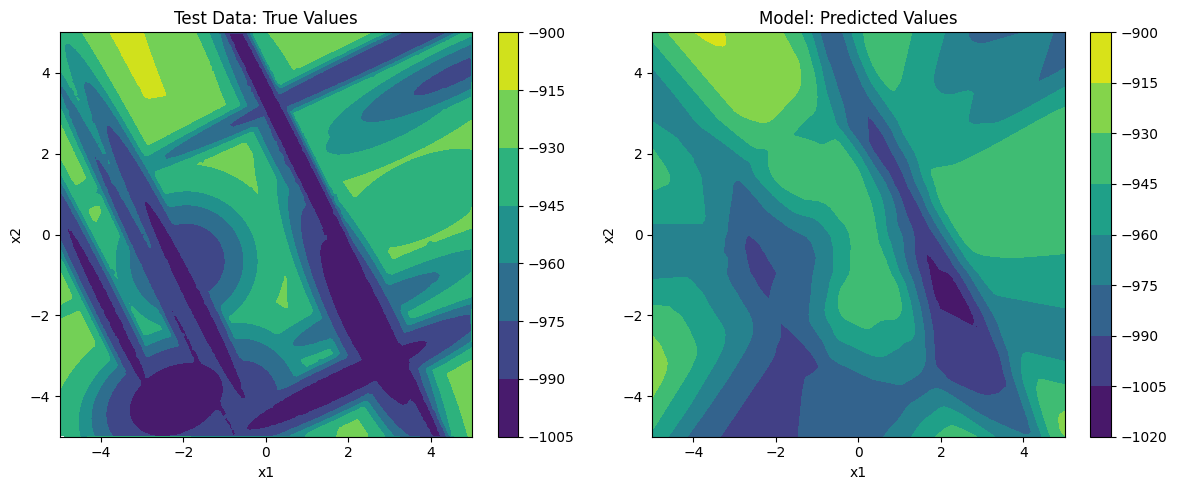

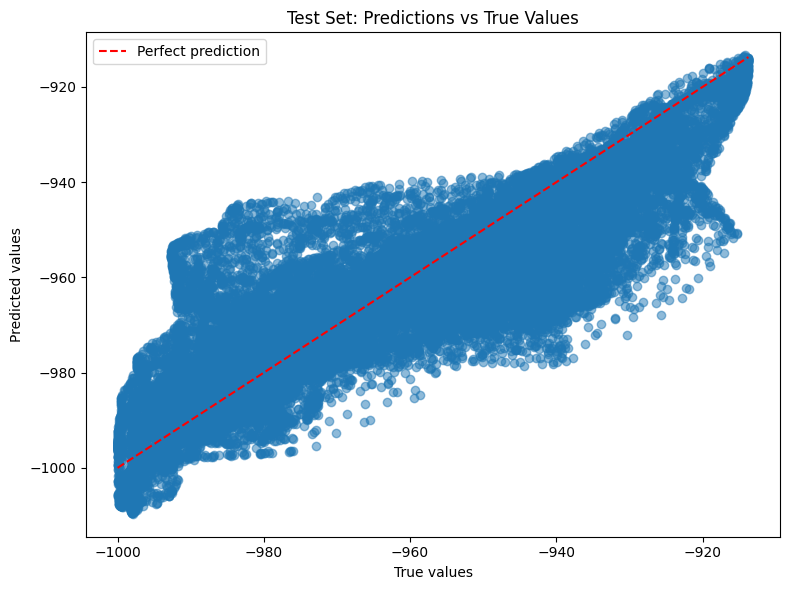

In [37]:
# train_perc + val_perc = 0.7


for train_size in train_set_sizes:
    train_perc = train_size / dataset_size

    train_dataloader, val_dataloader, test_dataloader = prepare_dataloaders(
    "./bbob_f022_i01_d02_samples.csv", train_perc=train_perc, val_perc=test_perc - train_perc
    )

    print(f"Train set size: {len(train_dataloader) * 256}")
    print(f"Valid set size: {len(val_dataloader) * 256}")
    print(f"Test set size: {len(test_dataloader) * 256}")

    model = MLP().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 100

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, targets in train_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        train_loss = train_loss / len(train_dataloader.dataset)
        train_losses.append(train_loss)
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_dataloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
        val_loss = val_loss / len(val_dataloader.dataset)
        val_losses.append(val_loss)
        if (epoch + 1) % 10 == 0:
            print(
                f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
            )

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)

    test_loss = test_loss / len(test_dataloader.dataset)
    print(f"Test Loss: {test_loss:.4f}")

    plot_contour_comparison(model, test_dataloader, device)
    plot_prediction_scatter(model, test_dataloader, device)


### Exercise 2: Optimization Robustness
- **Task:** Implement the `optimize_model` function to find inputs that minimize the model's output.
- **Instructions:**
  1. Execute the optimization process multiple times (e.g. 10 for each dataset) with different random starting points and record the best surrogate values.
  2. Create a histogram of the best `y` values across all optimization runs to visualize the distribution of results.
  3. Generate a contour plot showing the locations of the solutions found. Analyze the consistency of these solutions.
  4. Use `cocoex` to evaluate the true objective function at the solution points. Compare these values against the surrogate’s predicted values.

### Accessing Original COCO Benchmark Problems

The code below installs and imports the necessary packages to access the original COCO benchmark problems (f1 and f22).
This will allow us to compare our model's predictions with the true functions and evaluate optimization performance.

In [ ]:
! pip install coco-experiment cocopp

In [ ]:
from cocoex import Suite

function_id = 22  # Switch between 1 and 22 to change the function

suite = Suite(
    "bbob",
    "",
    f"function_indices: {function_id}, dimensions: 2 instance_indices: 1",
)
for function in suite:
    print(function.info)
    print("Function value at (0, 0):", function(np.array([0, 0])))